### FastText 단어 임베딩 기법을 활용한 텍스트 시각화

#### FastText

* 페이스북에서 개발해 공개한 단어 임베딩 기법
* 각 단어를 문자 단위 n-gram으로 표현하는 것이 특징.
* 따라서 조사와 어미가 발달한 한국어에 좋은 성능을 낼 수 있다는 강점에 따라 기사 크롤링 데이터에 적합하다고 판단.

1. "노인 모바일 뱅킹" 키워드로 크롤링한 기사 본문 데이터 활용
2. Mecab 형태소 분석기를 통해 형태소 분석 시행 => Mecab이 다른 형태소 분석기 대비 속도가 가장 빠르고, 형태소 분석 품질도 좋은 편.
3. FastText 임베딩 시행
4. 단어 벡터 시각화 => t-SNE 차원축소방식을 통해 단어 벡터를 2차원으로 축소하여 그래프에 표현


-----

In [1]:
#!pip install fasttext

In [23]:
#라이브러리
import gensim 
import gensim.models as g
from gensim.models import FastText
import pandas as pd
import numpy as np
from konlpy.tag import Mecab

from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

In [24]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [25]:
import openpyxl
from itertools import islice

wb = openpyxl.load_workbook("크롤링(노인모바일뱅킹).xlsx")
ws = wb.active
data = pd.DataFrame(ws.values)

In [26]:
data.columns = data.iloc[0,:]
data = data[1:]

In [6]:
data.head(1)

,NaN,years,company,title,contents,link
1,0.0,2021.07.22.,아시아경제신문,더 가까워진 비대면 서비스…더 멀어진 노인들의 일상,코로나19로 은행 영업시간 단축ATM·인터넷 사용법 어려워음식점 등 키오스크 확대눈...,https://news.naver.com/main/read.naver?mode=LS...


#데이터 불러오기
data = pd.read_excel("크롤링(노인모바일뱅킹).xlsx", usecols=["contents"])
data[:5]

#### [크롤링 데이터]

검색 키워드 : 노인모바일뱅킹

기사 날짜 기간 : 2017.01.01 ~ 2021.08.01

크롤링 기사 개수 :

검색 포털 : 네이버 뉴스 기준

In [27]:
#Null 값 존재 확인 및 제거
print("Null 값 : ", data.isnull().values.any())

#제거
data = data.dropna(how = "any")
print("제거")
print("Null 값 : ", data.isnull().values.any())

#기사개수
print("기사개수 : ", len(data))

Null 값 :  True
제거
Null 값 :  False
기사개수 :  351


In [8]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [28]:
#Mecab 형태소 분석기를 활용한 토큰화 및 불용어 처리 작업 (다소 시간 소요)
m = Mecab("C:\\mecab\\mecab-ko-dic")
tokens = []

#불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도',
             '를','으로','자','에','와','한','하다','김주연', '기자', "연합뉴스",
             '네이버', '서울', '신문', '구독', '세상', '나우', '뉴스', 
             '인기', '무료', '만화', '서울', '신문', '무단', '전재', '배포', '금지']

#명사로 형태소 분석 및 불용어 제거, 단어 길이 1 이하 제거
for sentence in data["contents"]:
    token = m.nouns(sentence)
    token = [word for word in token if word not in stopwords and len(word)>1]
    tokens.append(token)

In [48]:
#FastText 임베딩

# FastText 모델 학습
ft_model = FastText(tokens, vector_size=100,   #벡터 차원수(의미있는 단어를 가지고 학습하기 위해 적은 빈도 수의 단어들은 학습하지 않음)
                    window=5,      #context window 크기
                    min_count=5,   #단어에 대한 최소 빈도수
                    workers=1,     #학습 시 사용하는 프로세스 개수
                    sg=1, #n-gram 사용
                   seed=1)   

In [49]:
# 완성된 임베딩 매트릭스의 크기 확인
ft_model.wv.vectors.shape

(3322, 100)

In [50]:
# "노년층"과 가장 유사한 단어 30개 뽑기
ft_model.wv.most_similar("노년층", topn=30)

[('청년층', 0.918968141078949),
 ('저조', 0.9113243818283081),
 ('노년', 0.9110921025276184),
 ('중년층', 0.9081137776374817),
 ('장년층', 0.8894791603088379),
 ('문맹', 0.8865789175033569),
 ('사각', 0.8853641152381897),
 ('심화', 0.8796265721321106),
 ('애인', 0.8761686086654663),
 ('장년', 0.8658528327941895),
 ('증장', 0.864011287689209),
 ('격차', 0.8624281287193298),
 ('이해력', 0.8596473932266235),
 ('농어민', 0.8570486307144165),
 ('전락', 0.8547630906105042),
 ('소외감', 0.8524591326713562),
 ('서퍼', 0.851630687713623),
 ('성별', 0.8500465154647827),
 ('접근성', 0.8423720002174377),
 ('사각지대', 0.8421821594238281),
 ('현상', 0.8419418334960938),
 ('실태', 0.8411138653755188),
 ('접근', 0.8394996523857117),
 ('장벽', 0.8392592072486877),
 ('실생활', 0.8377042412757874),
 ('점수', 0.8368406295776367),
 ('주저', 0.8356730937957764),
 ('디지털', 0.8323546648025513),
 ('불리', 0.8317371606826782),
 ('대사', 0.8317018747329712)]

"문맹", "이해력", "소외감", "격차", "무인화" 등의 단어를 통해 노년층의 어려움을 확인

In [14]:
# "디지털"과 가장 유사한 단어 30개 뽑기
ft_model.wv.most_similar("디지털", topn=30)

[('문맹', 0.865678071975708),
 ('사각', 0.8616730570793152),
 ('타임스', 0.8571783304214478),
 ('노년', 0.8516654372215271),
 ('심화', 0.8505479097366333),
 ('이드', 0.8439550399780273),
 ('변혁', 0.8379271626472473),
 ('사각지대', 0.8365693688392639),
 ('급속도', 0.836293637752533),
 ('노년층', 0.8353151679039001),
 ('일환', 0.830277681350708),
 ('디바', 0.8288453221321106),
 ('전락', 0.8260716199874878),
 ('소외감', 0.8217889070510864),
 ('전환기', 0.8163947463035583),
 ('그림자', 0.8159345984458923),
 ('완화', 0.8136468529701233),
 ('농어민', 0.8134019374847412),
 ('이해력', 0.8129876255989075),
 ('대사', 0.8122668862342834),
 ('배제', 0.810004472732544),
 ('급변', 0.8097063302993774),
 ('격차', 0.8087518811225891),
 ('전반', 0.8040375113487244),
 ('중년층', 0.8040099143981934),
 ('주력', 0.8017537593841553),
 ('편익', 0.7999303936958313),
 ('접근', 0.7988994717597961),
 ('국장', 0.7954052090644836),
 ('흐름', 0.7929359674453735)]

"노인모바일뱅킹"이라는 키워드 속에 나온 "디지털"이라는 단어와 유사한 단어들이

"문맹", "소외감", "저조", "배제" 등의 단어임을 알 수 있었다.

이는 노인들의 디지털 활용에 고충이 있음을 파악 가능.

-----

#### 단어 벡터 시각화

In [51]:
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처 
mpl.rcParams['axes.unicode_minus'] = False 
plt.rc('font', family='D2Coding')

In [57]:
#t-SNE 차원축소
vocab = list(ft_model.wv.index_to_key)
X = ft_model.wv[vocab]

tsne = TSNE(n_components=2,metric='cosine', perplexity=10,random_state=1)

# 모든 단어를 그래프에 출력하면 글자가 너무 많이 겹치기 때문에 일부 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:200,:])

C:\Users\Oh Won Jin\anaconda3\envs\test\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [58]:
#x, y값 확인
df = pd.DataFrame(X_tsne, index=vocab[:200], columns=['x', 'y'])
df.head(20)

,x,y
은행,31.126339,-4.963913
금융,15.737132,-16.696009
서비스,16.879314,0.415795
디지털,-3.418337,10.713238
뱅킹,-12.145305,2.696577
고객,25.575924,-8.860277
모바일,-14.121812,1.246269
이용,-16.020739,3.099140
노인,8.504662,9.179707
인터넷,-15.215073,0.596948


#!폰트 설정 필요!

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="C:\\Users\\lovej\\AppData\\Local\\Microsoft\\Windows\\Fonts\\a고딕16.ttf").get_name()
rc('font', family=font_name)

import matplotlib.font_manager as fm
fontpath = 'c:/Windows/Fonts/malgun.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [62]:
df = pd.read_csv('t-SNE_data.csv')
df = df.set_index(df.columns[0])

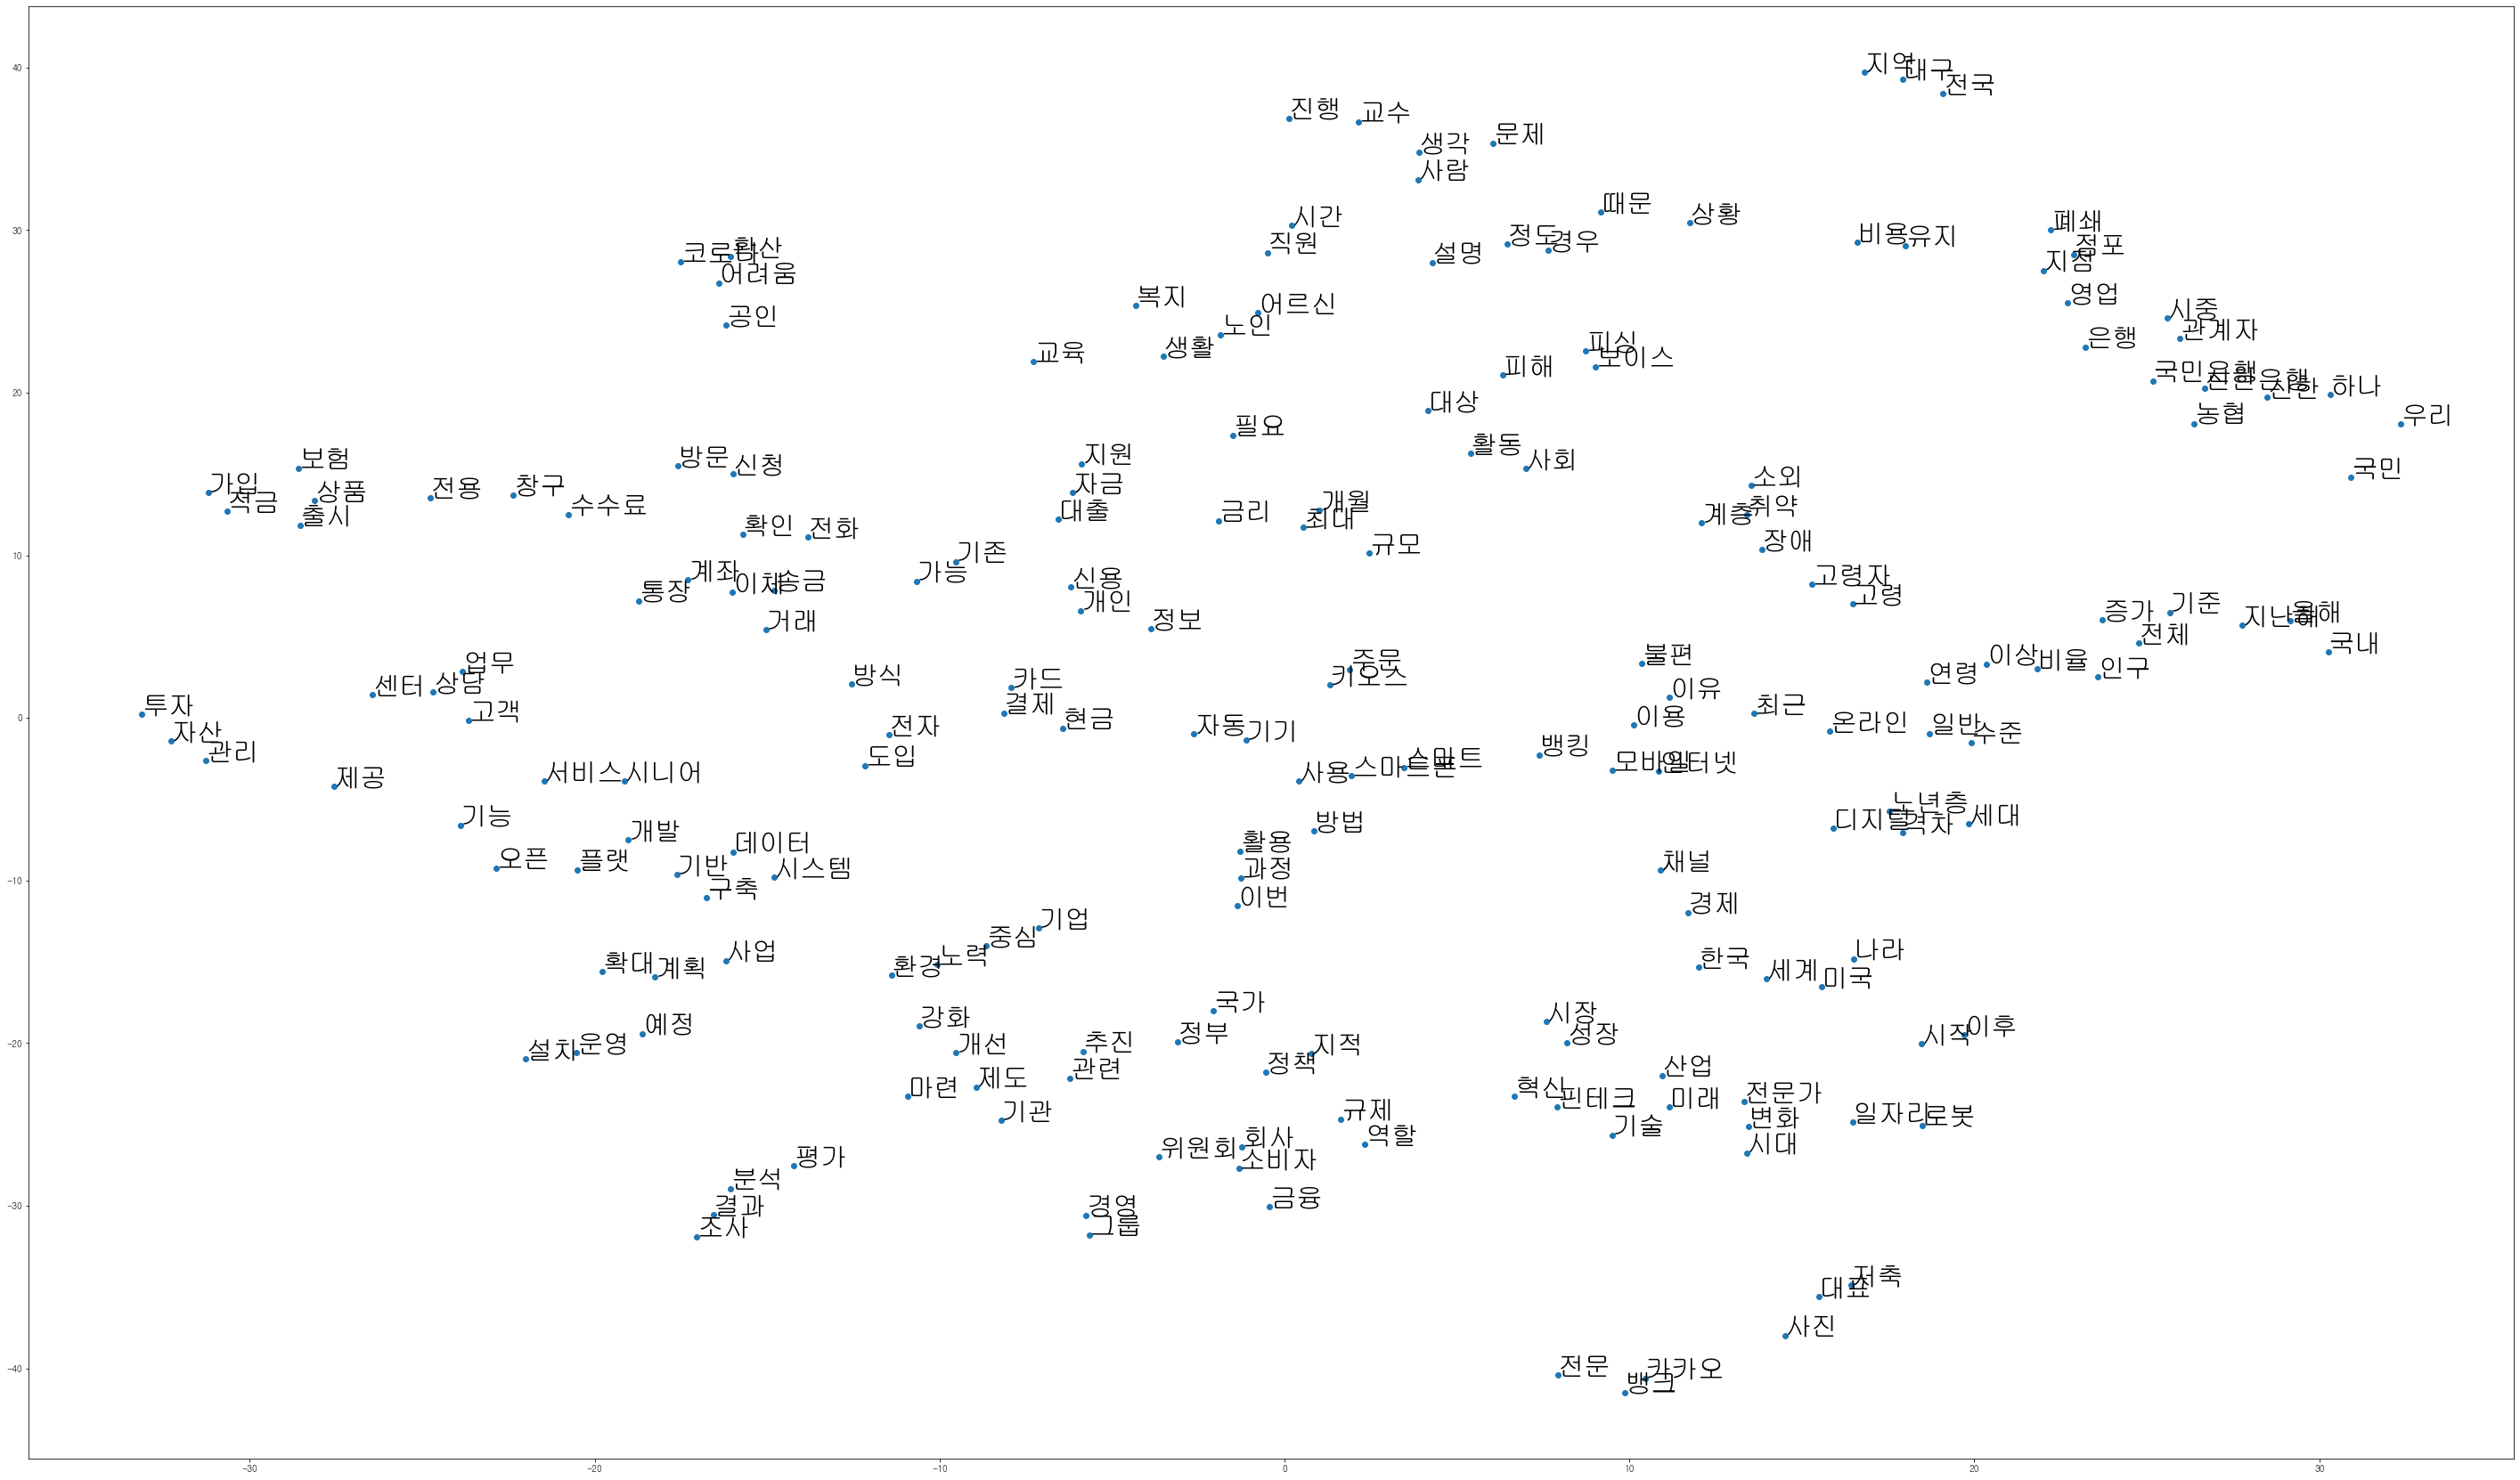

In [63]:
#그래프 나타내기
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

fig = plt.figure(figsize=(28,21))

fig.set_size_inches(50, 30)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

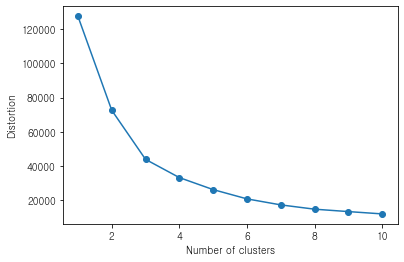

In [67]:
from sklearn.cluster import KMeans
seed = 1

distortions = []

for i in range(1, 11):
    km = KMeans(n_clusters = i, random_state = seed)
    km.fit(df)
    distortions.append(km.inertia_) # inertia_는 군집 내 분산을 의미하는 것!!
    
plt.plot(range(1, 11), distortions, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [68]:
km = KMeans(n_clusters = 5, random_state = seed)
km.fit(df)
new_labels = km.labels_

In [69]:
df['label'] = new_labels

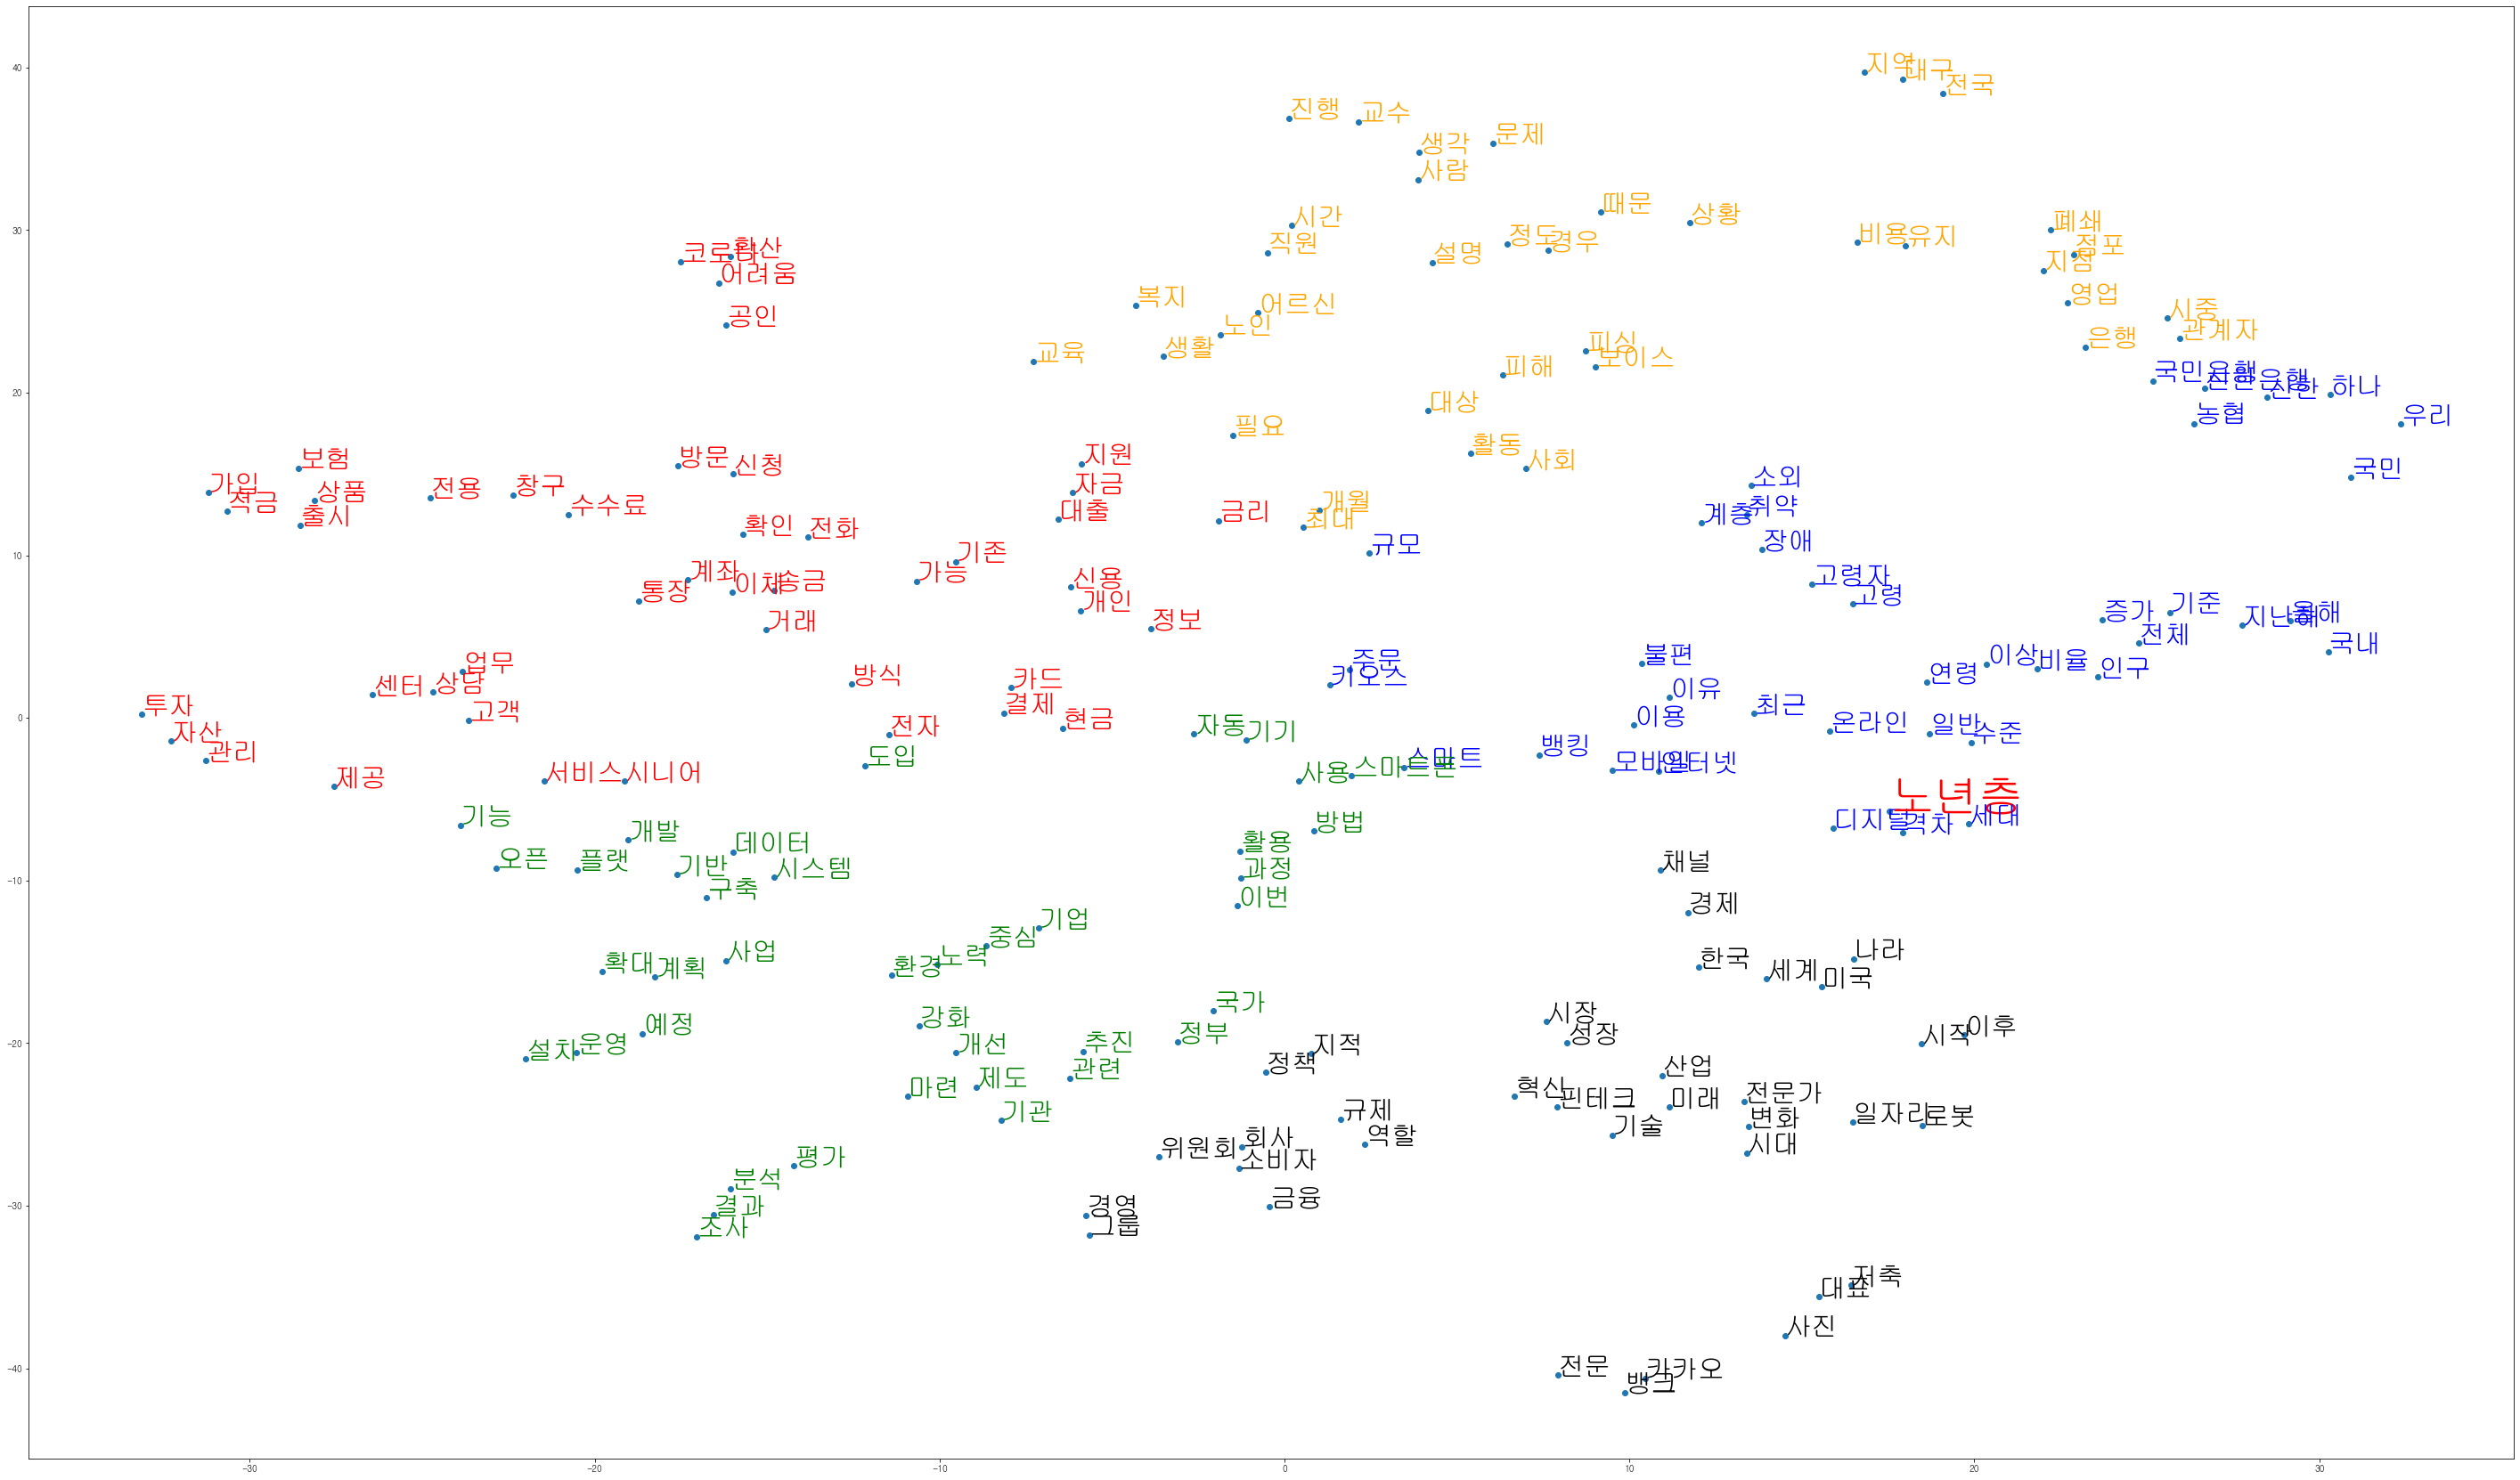

In [76]:
#그래프 나타내기
fig = plt.figure(figsize=(28,21))

fig.set_size_inches(50, 30)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

col = ['green','blue','red','black','orange']
for i in df.label.unique():
    for j in range(len(df[df.label == i])):
        if temp.index[j] == '노년층':
            temp = df[df.label == i]
            ax.text(temp['x'][j],temp['y'][j],temp.index[j],color = 'red', fontsize=50)
        else :
            temp = df[df.label == i]
            ax.text(temp['x'][j],temp['y'][j],temp.index[j],color = col[i], fontsize=30)
plt.show()